In [14]:
%kaggle competitions download -c histopathologic-cancer-detection

UsageError: Line magic function `%kaggle` not found.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import os
import cv2


import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization, Activation
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import roc_auc_score, accuracy_score
from PIL import Image
from keras.optimizers import Adam



path = r"C:\Users\sasan\Downloads\hist_cancer\\"
%cd "C:\Users\sasan\Downloads\hist_cancer"
%ls

C:\Users\sasan\Downloads\hist_cancer
 Volume in drive C is Acer
 Volume Serial Number is 4C88-CF93

 Directory of C:\Users\sasan\Downloads\hist_cancer

04/06/2023  12:07 PM    <DIR>          .
04/06/2023  08:28 PM    <DIR>          ..
04/06/2023  12:07 PM         2,470,703 sample_submission.csv
04/05/2023  09:11 PM    <DIR>          test
04/05/2023  11:08 PM    <DIR>          train
04/06/2023  12:03 PM         9,461,084 train_labels.csv
               2 File(s)     11,931,787 bytes
               4 Dir(s)  72,679,006,208 bytes free


In [24]:
labels_df = pd.read_csv(path+'train_labels.csv')
labels_df['id'] = labels_df['id'] + '.tif'
labels_df['label'] = labels_df['label'].astype(str)
print(labels_df.head().to_markdown())
print(labels_df.shape)

|    | id                                           |   label |
|---:|:---------------------------------------------|--------:|
|  0 | f38a6374c348f90b587e046aac6079959adf3835.tif |       0 |
|  1 | c18f2d887b7ae4f6742ee445113fa1aef383ed77.tif |       1 |
|  2 | 755db6279dae599ebb4d39a9123cce439965282d.tif |       0 |
|  3 | bc3f0c64fb968ff4a8bd33af6971ecae77c75e08.tif |       0 |
|  4 | 068aba587a4950175d04c680d38943fd488d6a9d.tif |       0 |
(220025, 2)


In [8]:
# Checking duplicates, none found
labels_df[labels_df.duplicated(keep=False)]

,id,label


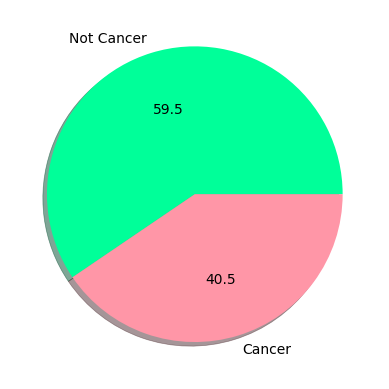

<Figure size 800x800 with 0 Axes>

In [4]:
labels_count = labels_df.label.value_counts()

%matplotlib inline
plt.pie(labels_count, labels=['Not Cancer', 'Cancer'], startangle=0, 
        autopct='%1.1f', colors=['#00ff99','#FF96A7'], shadow=True)
plt.figure(figsize=(8,8))
plt.show()

(96, 96, 3)


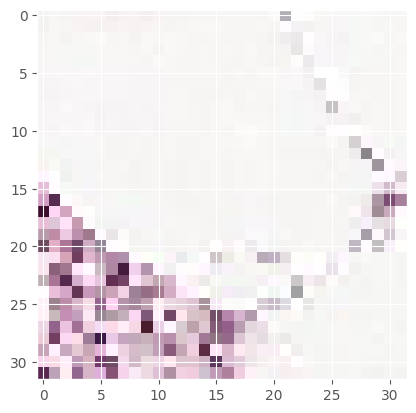

In [9]:
# Read an image file
img = cv2.imread(path+'/train/'+labels_df.iloc[0,0])
print(img.shape)
# Resize the image
resized = cv2.resize(img, (32, 32))

# Display the resized image
plt.imshow(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

In [16]:
# source: https://www.kaggle.com/gpreda/honey-bee-subspecies-classification

def draw_category_images(col_name,figure_cols, df, IMAGE_PATH):
    
    """
    Give a column in a dataframe,
    this function takes a sample of each class and displays that
    sample on one row. The sample size is the same as figure_cols which
    is the number of columns in the figure.
    Because this function takes a random sample, each time the function is run it
    displays different images.
    """
    
    categories = (df.groupby([col_name])[col_name].nunique()).index
    f, ax = plt.subplots(nrows=len(categories),ncols=figure_cols, 
                         figsize=(3*figure_cols,3*len(categories))) # adjust size here
    # draw a number of images for each location
    for i, cat in enumerate(categories):
        sample = df[df[col_name]==cat].sample(figure_cols) # figure_cols is also the sample size
        for j in range(0,figure_cols):
            file=IMAGE_PATH + sample.iloc[j]['id'] + '.tif'
            im=cv2.imread(file)
            ax[i, j].imshow(im, resample=True, cmap='gray')
            ax[i, j].set_title(cat, fontsize=16)  
    plt.tight_layout()
    plt.show()

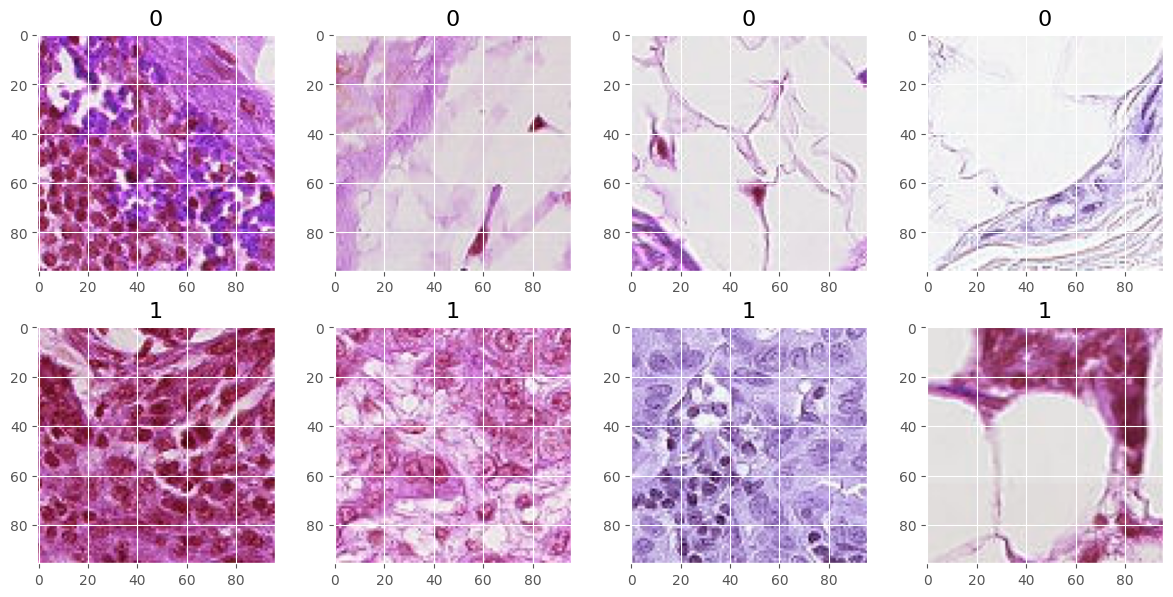

In [17]:
IMAGE_PATH = path+'/train/' 

draw_category_images('label',4, labels_df, IMAGE_PATH)

In [31]:

model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

batch_size = 256

model.build(input_shape=(batch_size, 48, 48, 3))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (256, 46, 46, 16)         448       
                                                                 
 conv2d_9 (Conv2D)           (256, 44, 44, 16)         2320      
                                                                 
 max_pooling2d_4 (MaxPooling  (256, 22, 22, 16)        0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (256, 20, 20, 32)         4640      
                                                                 
 conv2d_11 (Conv2D)          (256, 18, 18, 32)         9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (256, 9, 9, 32)          0         
 2D)                                                  

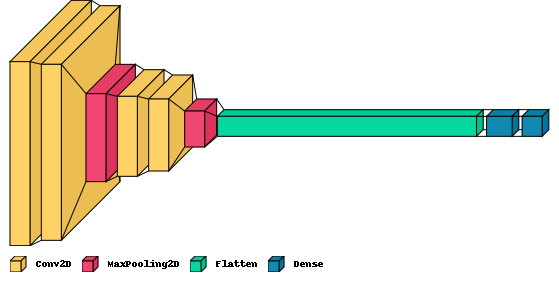

In [21]:
os.system('pip install visualkeras')
import visualkeras
visualkeras.layered_view(model, legend=True)

In [25]:
IMAGE_PATH = path+'/train/' 

generator = ImageDataGenerator(rescale=1./255, validation_split=0.25)

data_train = generator.flow_from_dataframe(
    dataframe = labels_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=IMAGE_PATH,
    subset='training',
    class_mode='binary',
    batch_size=batch_size,
    target_size=(48, 48))

data_validate=generator.flow_from_dataframe(
    dataframe=labels_df,
    x_col='id', # filenames
    y_col='label', # labels
    directory=IMAGE_PATH,
    subset="validation",
    class_mode='binary',
    batch_size=batch_size,
    target_size=(48, 48))

Found 165019 validated image filenames belonging to 2 classes.
Found 55006 validated image filenames belonging to 2 classes.


In [32]:

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

hist = model.fit(data_train, validation_data=data_validate, epochs=10)

Epoch 1/10
645/645 [==============================] - 2032s 3s/step - loss: 0.4932 - accuracy: 0.7641 - val_loss: 0.4593 - val_accuracy: 0.7903
Epoch 2/10
645/645 [==============================] - 1325s 2s/step - loss: 0.4573 - accuracy: 0.7895 - val_loss: 0.4488 - val_accuracy: 0.7937
Epoch 3/10
645/645 [==============================] - 1223s 2s/step - loss: 0.4422 - accuracy: 0.7982 - val_loss: 0.4276 - val_accuracy: 0.8074
Epoch 4/10
645/645 [==============================] - 1213s 2s/step - loss: 0.4270 - accuracy: 0.8057 - val_loss: 0.4147 - val_accuracy: 0.8134
Epoch 5/10
645/645 [==============================] - 1216s 2s/step - loss: 0.4118 - accuracy: 0.8145 - val_loss: 0.4125 - val_accuracy: 0.8126
Epoch 6/10
645/645 [==============================] - 1239s 2s/step - loss: 0.3998 - accuracy: 0.8208 - val_loss: 0.3885 - val_accuracy: 0.8278
Epoch 7/10
645/645 [==============================] - 1364s 2s/step - loss: 0.3899 - accuracy: 0.8260 - val_loss: 0.3819 - val_accuracy:

In [39]:
model.save(r"C:\Users\sasan\OneDrive\Desktop\hist_cancer\CNN_basic.h5")


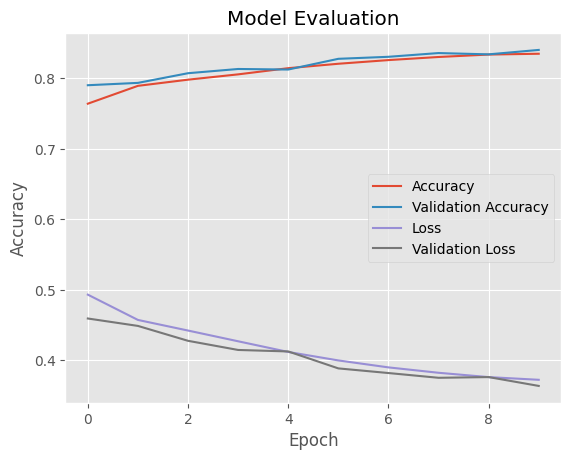

In [40]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])

plt.title("Model Evaluation")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy","Loss","Validation Loss"])

plt.show()

In [41]:
test_path = path+'\\test\\'
images_test = pd.DataFrame({'id':os.listdir(test_path)})

generator_testing = ImageDataGenerator(rescale=1./255)

data_test = generator_testing.flow_from_dataframe(
    dataframe = images_test,
    x_col='id', 
    directory=test_path,
    class_mode=None,
    batch_size=1,
    target_size=(48, 48),
    shuffle=False)

Found 57458 validated image filenames.


In [44]:
predictions = model.predict(data_test, verbose=1)
print(predictions)

57458/57458 [==============================] - 538s 9ms/step
[[0.65235925]
 [0.82564133]
 [0.21540327]
 ...
 [0.04806612]
 [0.9116464 ]
 [0.04023504]]


In [45]:
df = pd.DataFrame(predictions)
df.to_csv(r"C:\Users\sasan\OneDrive\Desktop\hist_cancer\CNN_basic_preds.csv", index=False, header=False)
